<a href="https://colab.research.google.com/github/dmsandipan/ML_Models/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb

#Python standard libraries
import time
import warnings

#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 200

In [ ]:
#loading data into dataframe obejcts
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)


Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
df_train.head()

,class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b.tag,...,jet4phi,jet4b.tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,id
0,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343,1
1,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118,2
2,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904,3
3,0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818,4
4,1,0.409391,-1.884684,-1.027292,1.672452,-1.604598,1.338015,0.055427,0.013466,2.173076,...,1.377130,3.101961,0.869418,1.222083,1.000627,0.545045,0.698653,0.977314,0.828786,5


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68636 entries, 0 to 68635
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   class                     68636 non-null  int64  
 1   lepton_pT                 68636 non-null  float64
 2   lepton_eta                68636 non-null  float64
 3   lepton_phi                68636 non-null  float64
 4   missing_energy_magnitude  68636 non-null  float64
 5   missing_energy_phi        68636 non-null  float64
 6   jet1pt                    68636 non-null  float64
 7   jet1eta                   68636 non-null  float64
 8   jet1phi                   68636 non-null  float64
 9   jet1b.tag                 68636 non-null  float64
 10  jet2pt                    68636 non-null  float64
 11  jet2eta                   68636 non-null  float64
 12  jet2phi                   68636 non-null  float64
 13  jet2b.tag                 68636 non-null  float64
 14  jet3pt

In [ ]:
#dropping id columns
df_train.drop(df_train.columns[-1], axis=1, inplace=True)
df_test.drop(df_test.columns[-1], axis=1, inplace=True)

In [ ]:
#train test split with randomization performed (although randomization is not necessary)
X_train, X_test, y_train, y_test = train_test_split(df_train.iloc[:,1:], df_train.iloc[:,:1], test_size=0.2, random_state=122, stratify=df_train.iloc[:,:1])

In [ ]:
missing_props = df_train.isna().mean(axis=0)

In [ ]:
missing_props

class                       0.0
lepton_pT                   0.0
lepton_eta                  0.0
lepton_phi                  0.0
missing_energy_magnitude    0.0
missing_energy_phi          0.0
jet1pt                      0.0
jet1eta                     0.0
jet1phi                     0.0
jet1b.tag                   0.0
jet2pt                      0.0
jet2eta                     0.0
jet2phi                     0.0
jet2b.tag                   0.0
jet3pt                      0.0
jet3eta                     0.0
jet3phi                     0.0
jet3b.tag                   0.0
jet4pt                      0.0
jet4eta                     0.0
jet4phi                     0.0
jet4b.tag                   0.0
m_jj                        0.0
m_jjj                       0.0
m_lv                        0.0
m_jlv                       0.0
m_bb                        0.0
m_wbb                       0.0
m_wwbb                      0.0
dtype: float64

In [ ]:
cat_cols = df_train.select_dtypes(exclude="number").columns
num_cols = df_train.select_dtypes(include="number").columns

In [ ]:
cat_cols

Index([], dtype='object')

In [ ]:
num_cols

Index(['class', 'lepton_pT', 'lepton_eta', 'lepton_phi',
       'missing_energy_magnitude', 'missing_energy_phi', 'jet1pt', 'jet1eta',
       'jet1phi', 'jet1b.tag', 'jet2pt', 'jet2eta', 'jet2phi', 'jet2b.tag',
       'jet3pt', 'jet3eta', 'jet3phi', 'jet3b.tag', 'jet4pt', 'jet4eta',
       'jet4phi', 'jet4b.tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb',
       'm_wbb', 'm_wwbb'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
accuracy_score(y_test, preds)

0.71875

In [ ]:
xgb_cl

XGBClassifier()

In [ ]:
param_grid = {
    "max_depth": [3, 4],
    "learning_rate": [0.1, 0.01],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
grid_cv

GridSearchCV(estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'gamma': [0, 0.25, 1],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 4],
                         'reg_lambda': [0, 1], 'subsample': [0.8]},
             scoring='roc_auc')

In [ ]:
grid_cv.best_score_

0.7909248967243317

In [ ]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 1,
 'subsample': 0.8}

In [ ]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_,
    objective="binary:logistic"
)

In [ ]:
from sklearn.metrics import roc_auc_score

_ = final_cl.fit(X_train, y_train)

preds = final_cl.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
roc_auc_score(y_test, preds)

0.7189742294174004

[0.03542661 0.01108949 0.00812429 0.03896153 0.00929792 0.06543775
 0.01331064 0.00872631 0.04378772 0.04123272 0.01258929 0.01179422
 0.02248921 0.02344522 0.0127502  0.00955948 0.02262094 0.0211142
 0.01153845 0.0111967  0.01888661 0.03363335 0.08040221 0.025559
 0.0656179  0.16031864 0.09335426 0.08773504]


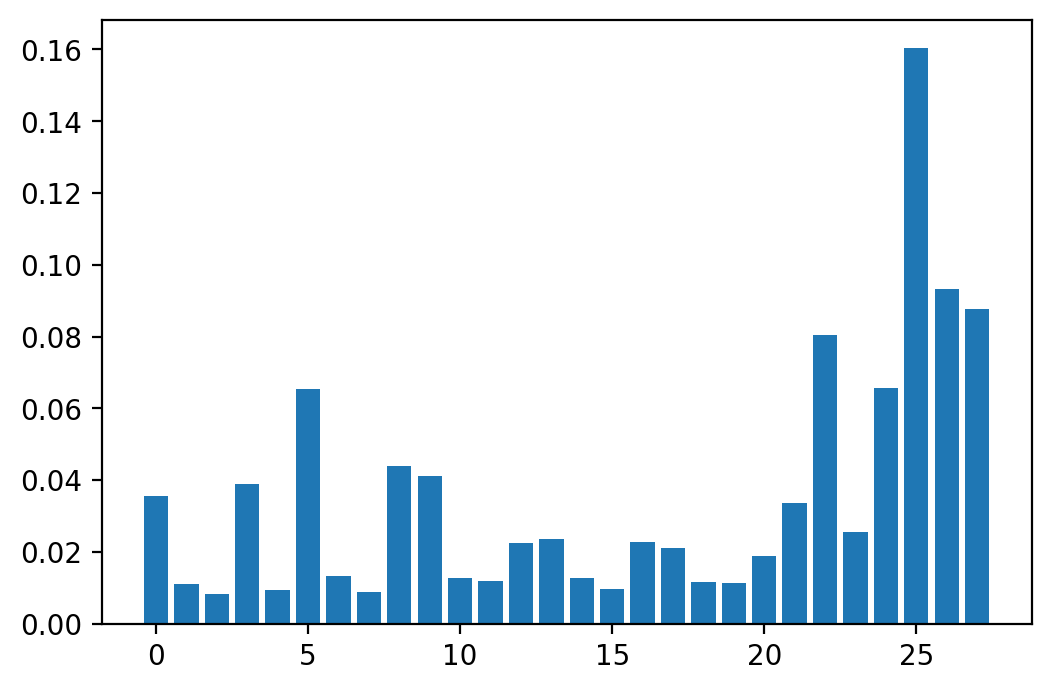

In [ ]:
from matplotlib import pyplot
print(final_cl.feature_importances_)
# plot
pyplot.bar(range(len(final_cl.feature_importances_)), final_cl.feature_importances_)
pyplot.show()

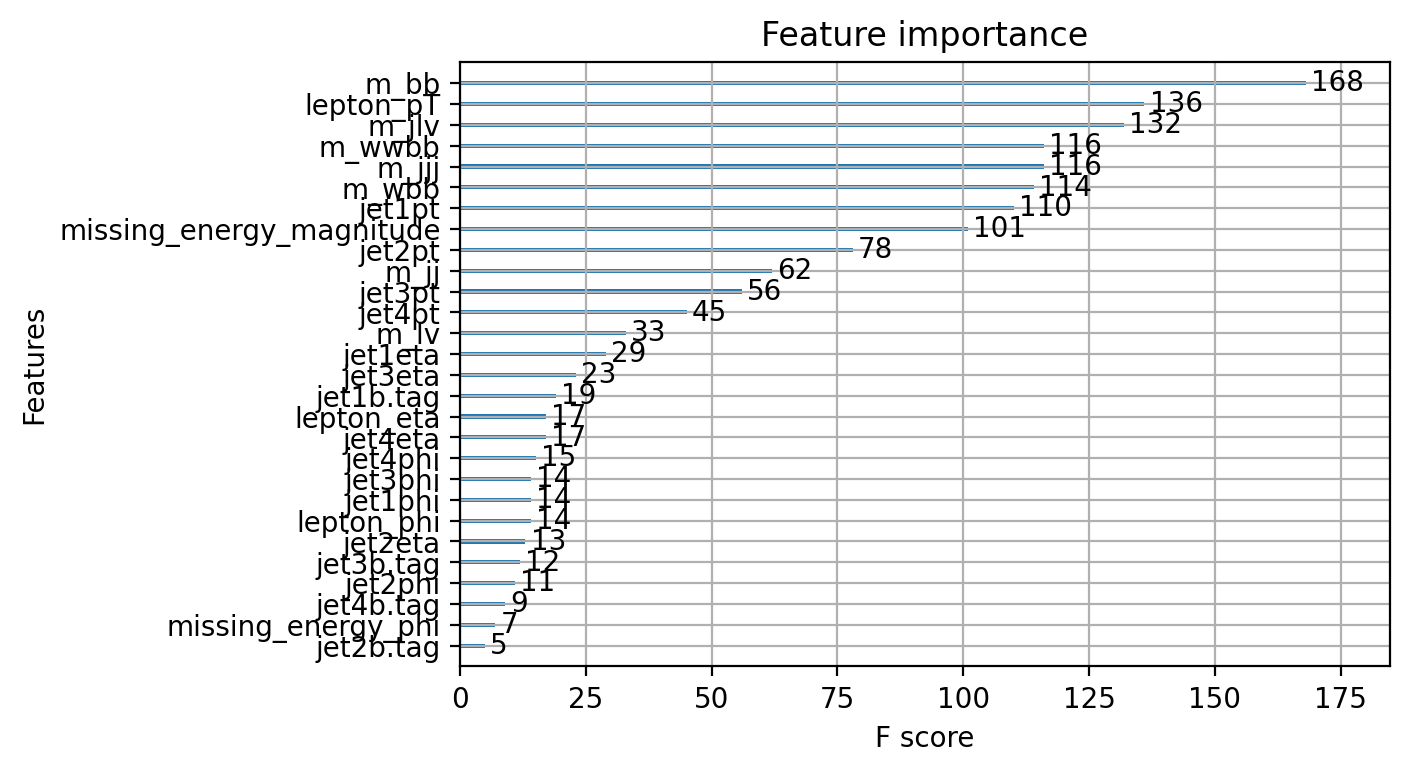

In [ ]:
from xgboost import plot_importance
plot_importance(final_cl)
pyplot.show()